# Binderhub Workflow and Tips
### Georgios Varnavides, Craig Carter 02/04/21

# Talk Overview

### 1. Sharing fully-interactive Jupyter notebook environments
- Binder introduction
- Dockerfile to use Python, WolframLanguage, and Julia kernels
- Speed up binder launch using github actions
- Seperate environment and content repos

### 2. Quick overview of the three kernels
- Discrete dynamical systems

### 3. Cross-languange integration libraries
- Wolfram Language's `ExternalEvaluate`
- Python's `Wolfram Client Library`

## Disclaimer:
- I'll assume zero `Docker` experience (which is also where I was at ~1 month ago)
- I'm fairly comfortable with the Wolfram Language, but increasingly less so with Python and Julia

## Credits:
- Huge thanks to Jesse Friedman and Arnoud Buzing at Wolfram Research, for WolframLicensing help
- Thanks to the binderhub team for their flexibility with egress ports
- Discrete dynamical systems example is adapted from Chris Rackauckas

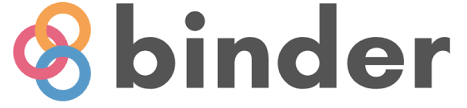

> Binder allows you to create custom computing environments that can be shared and used by many remote users. It is powered by BinderHub, which is an open-source tool that deploys the Binder service in the cloud. One such deployment lives at mybinder.org, and is free to use. 

- Essentially, `Binder` allows you to containerize a (public) repository of jupyter notebooks which can then be shared as interactive, reproducible environments  
[**mybinder.org demo**](https://github.com/binder-examples/demo-julia)

# What about the Wolfram Engine?

- `repo2docker`, the tool used by `BinderHub` to build images on demand, has built-in support for the following kernels:
  - Python (`environment.yml`/`requirements.txt`)
  - R (`install.R`)
  - Julia (`Project.toml`/`Manifest.toml`)
- For these languages, installation is easy using the configuration files listed above  
- If we want to build more complicated environments, we need to specify our own `Dockerfile`

## What is a `Dockerfile`?

>Docker is a tool that allows developers, sys-admins etc. to easily deploy their applications in a sandbox (called containers) to run on the host operating system i.e. Linux. The key benefit of Docker is that it allows users to package an application with all of its dependencies into a standardized unit for software development.

- Cool, so like virtual machines?

>Unlike virtual machines, containers do not have high overhead and hence enable more efficient usage of the underlying system and resources.

- `Dockerfile`s are recipes the `Docker` client follows to creat an image
  - If you're comfortable with Linux commands, `Dockerfile` commands are _almost identical_

#### Here's an example `Dockerfile`:

```dockerfile
FROM ubuntu

RUN apt-get update
RUN apt-get install -y python

ADD hello.py /home/hello.py
ADD hello-alternative.py /home/hello-alternative.py

CMD ["/home/hello.py"]
ENTRYPOINT ["python"]
```
#### Which does the following:
1. Starts using the ubuntu(:latest) image as base
2. Installs `python` using `apt-get`
3. Adds (copies) two python files from the host system to the container
4. Specifies a default `command` and `entrypoint` to run when called

#### Our python files
```python
# hello.py
print("Hello World")
```

```python
# hello-alternative.py
print("Alternative Hello")
```

#### Building and running
- We can build our simple docker image by running

```console
george@broadway:~$ docker build -t python-image .
```

- And then run the default command as:

```console
george@broadway:~$ docker run --name test1 python-image
Hello World
```
- Or overwrite and execute a different command inside the container:

```console
george@broadway:~$ docker run --name test2 python-image /home/hello-alternative.py
Alternative Hello
```

## Back to the Wolfram Engine
- So first, `Binder` works with public repositories and is accessible by anyone
  - This is great, but it clearly poses challenges for licensed software like the Wolfram Engine
  
  

- Recently, Wolfram Research released the [Free Wolfram Engine for Developers](https://www.wolfram.com/engine/)
  - This is still however a licensed piece of software, with the following licensing options:
    - Node-Locked Licensing; this won't work for us
    - On-Demand Licensing:
      - This new functionality (12.2), allows one to re-use a form of license key called an `entitlement-id`
      - and get charged `Service Credits` (for our purposes, this turns out to be peanuts)
     

## Binder `Dockerfile`  
- We'll use this `Dockerfile` to set-up our binder with Python, Julia, and the Wolfram Engine:

```dockerfile
# Dockerfile based on:
# https://github.com/jupyterhub/repo2docker/tree/2f1914d8d66395e151c82453290f51d8c0894bf4
FROM ubuntu:18.04

# ---- SETUP ----
ENV DEBIAN_FRONTEND=noninteractive

# Set up locales properly
# Set up certificates etc properly
RUN apt-get -qq update && \
    apt-get -qq install --yes --no-install-recommends locales \
    wget gnupg2 ca-certificates > /dev/null && \
    update-ca-certificates && \
    apt-get -qq purge && \
    apt-get -qq clean && \
    rm -rf /var/lib/apt/lists/*

RUN echo "en_US.UTF-8 UTF-8" > /etc/locale.gen && \
    locale-gen

ENV LC_ALL en_US.UTF-8
ENV LANG en_US.UTF-8
ENV LANGUAGE en_US.UTF-8

# Use bash as default shell, rather than sh
ENV SHELL /bin/bash

# Set up user
ARG NB_USER
ARG NB_UID
ENV USER ${NB_USER}
ENV HOME /home/${NB_USER}
RUN groupadd \
        --gid ${NB_UID} \
        ${NB_USER} && \
    useradd \
        --comment "Default user" \
        --create-home \
        --gid ${NB_UID} \
        --no-log-init \
        --shell /bin/bash \
        --uid ${NB_UID} \
        ${NB_USER}

RUN wget --quiet -O - https://deb.nodesource.com/gpgkey/nodesource.gpg.key |  apt-key add - && \
    DISTRO="bionic" && \
    echo "deb https://deb.nodesource.com/node_14.x $DISTRO main" >> /etc/apt/sources.list.d/nodesource.list && \
    echo "deb-src https://deb.nodesource.com/node_14.x $DISTRO main" >> /etc/apt/sources.list.d/nodesource.list

# install some base packages
RUN apt-get -qq update && \
    apt-get -qq install --yes --no-install-recommends \
    less unzip curl git build-essential \
    # WolframEngine dependencies
    xz-utils avahi-daemon netbase libgl1-mesa-glx libfontconfig1 libasound2 && \
    apt-get -qq purge && \
    apt-get -qq clean && \
    rm -rf /var/lib/apt/lists/*

EXPOSE 8888

# Environment variables required for build
ENV APP_BASE /srv
ENV CONDA_DIR ${APP_BASE}/conda
ENV WOLFRAM_DIR ${APP_BASE}/wolfram

# On-demand licensing env variables
ENV WOLFRAMSCRIPT_ENTITLEMENTID O-WSDS-9826-V6NRZS7WMDZMK 
ENV WOLFRAMINIT '-pwfile '\!cloudlm.wolfram.com' -entitlement O-WSDS-9826-V6NRZS7WMDZMK'

ENV NB_PYTHON_PREFIX ${CONDA_DIR}/envs/notebook
ENV KERNEL_PYTHON_PREFIX ${NB_PYTHON_PREFIX}
ENV JULIA_PATH ${APP_BASE}/julia
ENV JULIA_DEPOT_PATH ${JULIA_PATH}/pkg

ENV PATH ${NB_PYTHON_PREFIX}/bin:${CONDA_DIR}/bin:${JULIA_PATH}/bin:${PATH}

# Copy build scripts
COPY --chown=1000:1000 build-scripts/activate-conda.sh /etc/profile.d/activate-conda.sh
COPY --chown=1000:1000 build-scripts/environment.py-3.8.yml /tmp/environment.yml
COPY --chown=1000:1000 build-scripts/install-miniforge.bash /tmp/install-miniforge.bash

# ---- JUPYTER INSTALLATION: MAMBA ----
RUN TIMEFORMAT='time: %3R' && \
    chmod +x /tmp/install-miniforge.bash && \
    bash -c 'time /tmp/install-miniforge.bash' && \
    rm /tmp/install-miniforge.bash /tmp/environment.yml

ARG REPO_DIR=${HOME}
ENV REPO_DIR ${REPO_DIR}
WORKDIR ${REPO_DIR}
RUN chown ${NB_USER}:${NB_USER} ${REPO_DIR}

ENV PATH ${HOME}/.local/bin:${REPO_DIR}/.local/bin:${PATH}
ENV CONDA_DEFAULT_ENV ${KERNEL_PYTHON_PREFIX}

COPY --chown=1000:1000 ./environment.yml ${REPO_DIR}/environment.yml

USER ${NB_USER}
RUN TIMEFORMAT='time: %3R' \
    bash -c 'time mamba env update -p ${NB_PYTHON_PREFIX} -f "environment.yml" && \
    time mamba clean --all -f -y && \
    mamba list -p ${NB_PYTHON_PREFIX} \
   '

# ---- JULIA ----
USER root
ARG julia_version="1.6.0-beta1"
ENV JULIA_VERSION="${julia_version}"
RUN mkdir -p ${JULIA_PATH} && \
curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/${JULIA_VERSION%[.]*}/julia-${JULIA_VERSION}-linux-x86_64.tar.gz" | tar -xz -C ${JULIA_PATH} --strip-components 1

# Copy Project.toml and Manifest.toml
COPY --chown=1000:1000 ./*toml ${REPO_DIR}
RUN mkdir -p ${JULIA_DEPOT_PATH} && \
    chown ${NB_USER}:${NB_USER} ${JULIA_DEPOT_PATH} && \
    chown -R ${NB_USER}:${NB_USER} ${REPO_DIR}

# Note JSON, ZMQ, LinearAlgebra required for WL ExternalEvaluate
USER ${NB_USER}
RUN JULIA_PROJECT="" julia -e "using Pkg; Pkg.add([\"IJulia\",\"JSON\",\"ZMQ\",\"LinearAlgebra\"]); using IJulia; installkernel(\"Julia\", \"--project=${REPO_DIR}\");" && \
julia --project=${REPO_DIR} -e 'using Pkg; Pkg.instantiate(); pkg"precompile"'

# ---- WOLFRAM ENGINE ----
# Currently download url points to 12.2.0 - consider switching back to docker images for reproducibility
# https://hub.docker.com/r/wolframresearch/wolframengine
USER root
RUN mkdir -p ${WOLFRAM_DIR} && \
    chown -R ${NB_USER}:${NB_USER} ${WOLFRAM_DIR} && \
    wget https://account.wolfram.com/download/public/wolfram-engine/desktop/LINUX \
    -O /tmp/Install-WolframEngine.sh && \
    chmod +x /tmp/Install-WolframEngine.sh && \
    /tmp/Install-WolframEngine.sh -- -auto -verbose && \
    rm -f /tmp/Install-WolframEngine.sh

# add wolframengine jupyter kernel
USER ${NB_USER}
RUN cd ${WOLFRAM_DIR} && \
    git clone https://github.com/okofish/WolframLanguageForJupyter.git && \
    cd WolframLanguageForJupyter && \
    git checkout 1429f1c86b60ba79794eace378eae4f5941fc9cf -b feature/OnDemandLicensing && \
    ./configure-jupyter.wls add && \
    jupyter kernelspec list

# ---- WRAP UP ----
# Execute postBuild
COPY --chown=1000:1000 ./postBuild ${REPO_DIR}/postBuild
RUN chmod +x postBuild
RUN ./postBuild

# Add entrypoint
COPY --chown=1000:1000 build-scripts/repo2docker-entrypoint /usr/local/bin/repo2docker-entrypoint
RUN chmod +x /usr/local/bin/repo2docker-entrypoint
ENTRYPOINT ["/usr/local/bin/repo2docker-entrypoint"]

# Specify the default command to run
CMD ["jupyter", "notebook", "--ip", "0.0.0.0"]
```

- Which can be found in [this repository](https://github.com/gvarnavi/binder-env_py-3.8_jl-1.6_wl-12.2)  
 **Terminal demo**

## Speed up `Binder` build

- Simply pointing mybinder.org to a repository with this `Dockerfile` will work.
- What will happen is that the first time someone navigates to the binder link:
  - If the image has not yet been built on the server, `repo2docker` will first build it
    - and then launch a binder instance
  - If the image has been built, it will simply launch an instance
  
  
- This has two problems:
  1. Everytime we make a new commit, and someone visits the link, Binder will try and re-build the image (albeit using caching)
  2. A lot of the time building is spent installing some of our dependencies (julia and WL in particular take a while)


- The following is a clever hack to automate and speed up the process  
- It essentially makes use of the fact that we can simply `pull` a pre-built image in a `Dockerfile` using the `FROM` command

### Github Actions
- We will use a worklow or Github action to achieve this

```yaml
name: dockerhub-mybinder deployment
 
on: push

jobs:
  binder:
    runs-on: ubuntu-latest
    steps:
    - name: Checkout Code
      uses: actions/checkout@v2
      with:
        ref: ${{ github.event.pull_request.head.sha }}

    - name: update jupyter dependencies with repo2docker
      uses: jupyterhub/repo2docker-action@master
      with:
        DOCKER_USERNAME: ${{ secrets.DOCKER_USERNAME }}
        DOCKER_PASSWORD: ${{ secrets.DOCKER_PASSWORD }}
        BINDER_CACHE: true
```

- We need to do three things to enable this:  
  1. Set up a [Dockerhub account](https://hub.docker.com/)  
  2. Add the following two Repository secrets to our repo (repo>settings>secrets>actions)  
    - `DOCKER_PASSWORD` (you probably want to use an action-token instead)  
    - `DOCKER_USERNAME`  
  3. Commit the above yaml file as a new Workflow (repo>actions>new)  


**Github action demo**

# Separating Content and Environment Repositories

- Notice this will still start a new build (albeit asynchronously) for every new (pushed) commit  
- This could be a problem if you're designing a workshop, where you're making many (last minute) edits to the content notebooks, while keeping the environment intact  
- This can be conveniently solved using `nbgitpuller`  


- Essentially, we'll do the following:
  1. Create one binder [environment repository](https://github.com/gvarnavi/binder-env_py-3.8_jl-1.6_wl-12.2) (with only our `Dockerfile` and configuration files)
    - Note we need to include `nbgitpuller` in our python dependencies
  2. Create a separate [content repository](https://github.com/gvarnavi/python-julia-wolfram-workflow-nbs) (with all our notebooks)
  3. Build and launch Binder on the environment repository
    - Once an instance is launched, `git clone` our content repository
    
    
- This can all be automated using the `nbtgitpuller` [link generator](https://jupyterhub.github.io/nbgitpuller/link.html)
  - As a fun aside, they have hilarious loading messages  



**nbgitpuller demo**

# Let's (finally) see our Binder in action!



[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/gvarnavi/binder-env_py-3.8_jl-1.6_wl-12.2/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fgvarnavi%252Fpython-julia-wolfram-workflow-nbs%26urlpath%3Dtree%252Fpython-julia-wolfram-workflow-nbs%252F%26branch%3Dmain)